In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from loader import PathDataModule
from tqdm import tqdm

# --- 1. Configuration and Data Loading ---
config_path = 'config_score.json'
config_data = json.load(open(config_path, 'r'))
print(config_data)

{'dataset': 'icews14', 'storage_dir': '../data/', 'embedding_config': './embedding_config.json', 'criteria': 'score', 'train_ratio': 0.3, 'hidden_dim': 256, 'max_hops': 6, 'num_neg': 3, 'num_threads': 2, 'decay_factor': 0.2, 'max_fanout': 100, 'beam_width': 20, 'max_epochs': 1, 'batch_size': 8, 'dim_feedforward': 256, 'nhead': 4, 'num_layers': 6, 'dropout': 0.1, 'store': 'model', 'save_text_embeddings': True, 'shallow': True, 'pre_scan': ['train'], 'adjust_no_neg_paths_samples': True, 'max_adjust': 5.0, 'positive_deviation': True, 'embedding': 'all', 'test_time': 0, 'num_ckpt': 2, 'scale_loss': True, 'chi2': False, 'lr': 0.0001, 'wandb_project': 'thesis-graph'}


In [2]:
tqdm.pandas()

In [3]:
import os, requests, json, pprint

cid  = os.getenv("CONTAINER_ID")          # ← set by Vast.ai inside every container
key  = os.getenv("CONTAINER_API_KEY")     # ← scoped token for this one instance
assert cid and key, "Not running on a Vast.ai container!"

resp = requests.get(
    f"https://console.vast.ai/api/v0/instances/{cid}/",
    headers={"Authorization": f"Bearer {key}",
             "accept": "application/json"},
    timeout=10,
)

info = resp.json()
print("Effective vCPUs:", info['instances']["cpu_cores_effective"])
# print(info['instances'].keys())

Effective vCPUs: 24.0


In [4]:

# Initialize the DataModule and load the data
print("Setting up DataModule...")
dm = PathDataModule(config_path=config_path, batch_size=32)
dm.setup('fit')
print("Data loaded.")


Setting up DataModule...
Setting up data for stage: fit
Setting up data for split: train
Pre-scan enabled for train split. Running full data validation...

--- Pre-scanning and filtering train data points ---
Scanning 262570 edges in train split...


Scanning edges: 100%|██████████| 262570/262570 [00:00<00:00, 484811.98it/s]



Pre-scan Results for train:
  Total edges scanned: 262570
  Valid edges (has pos & neg paths): 202759 (77.2%)
  Missing positive paths: 59811 (22.8%)
  Missing negative paths: 143963 (54.8%)
  Empty negative paths: 0 (0.0%)

⚠️  WARNING: Some edges are missing required path data!
  Filtering train split to keep only 202759 valid edges.
  New edge count for train: 202759
--- Pre-scan complete ---

Use shallow embeddings: True at config ./embedding_config.json
Loading KGE model proxy for train split from ../data/transe_icews14_all_config.json
KGEModelProxy initialized on cuda
Loaded model state from ../data/transe_icews14_all_model.pt to cuda
Device for KGE model: cuda:0
Loaded 202759 edges for train split.
Setting up data for split: valid
Pre-scan not configured for valid split. Skipping data validation.
Use shallow embeddings: True at config ./embedding_config.json
Loading KGE model proxy for valid split from ../data/transe_icews14_all_config.json
KGEModelProxy initialized on cuda
Loa

In [5]:

# --- 2. Data Extraction and Preparation ---
plot_data = []
split = 'valid'  # You can change this to 'valid' or 'test'

print(f"Processing data for '{split}' split...")
edges_df = dm.data[split]
pos_paths = dm.pos_paths[split]
neg_paths = dm.neg_paths[split]


Processing data for 'valid' split...


In [6]:
print(len(pos_paths), len(neg_paths))

38825 24384


In [7]:
edges_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42570 entries, 307232 to 349801
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   feat_pos_u  42570 non-null  int64
 1   feat_pos_v  42570 non-null  int64
 2   u           42570 non-null  int64
 3   v           42570 non-null  int64
 4   u_type      42570 non-null  int64
 5   v_type      42570 non-null  int64
 6   ts          42570 non-null  int64
 7   split       42570 non-null  int64
 8   label       42570 non-null  int64
 9   edge_type   42570 non-null  int64
 10  v_pos       42570 non-null  int64
 11  length      42570 non-null  int64
dtypes: int64(12)
memory usage: 5.2 MB


In [8]:
edges_df[edges_df['v_pos'] == edges_df['v']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 17028 entries, 307232 to 349288
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   feat_pos_u  17028 non-null  int64
 1   feat_pos_v  17028 non-null  int64
 2   u           17028 non-null  int64
 3   v           17028 non-null  int64
 4   u_type      17028 non-null  int64
 5   v_type      17028 non-null  int64
 6   ts          17028 non-null  int64
 7   split       17028 non-null  int64
 8   label       17028 non-null  int64
 9   edge_type   17028 non-null  int64
 10  v_pos       17028 non-null  int64
 11  length      17028 non-null  int64
dtypes: int64(12)
memory usage: 1.7 MB


In [9]:
edges_df[edges_df['v_pos'] == edges_df['v']].describe()

,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos,length
count,17028.000000,17028.000000,17028.000000,17028.000000,17028.0,17028.0,17028.000000,17028.0,17028.0,17028.000000,17028.000000,17028.000000
mean,511.397992,511.397992,1073.443740,1073.443740,0.0,0.0,7645.099366,2.0,1.0,139.126028,1073.443740,2.192154
std,1023.577597,1023.577597,1669.046588,1669.046588,0.0,0.0,195.253569,0.0,0.0,118.093026,1669.046588,0.743377
min,0.000000,0.000000,0.000000,0.000000,0.0,0.0,7296.000000,2.0,1.0,0.000000,0.000000,0.000000
25%,14.000000,14.000000,72.000000,72.000000,0.0,0.0,7488.000000,2.0,1.0,16.000000,72.000000,2.000000
50%,93.000000,93.000000,321.000000,321.000000,0.0,0.0,7656.000000,2.0,1.0,228.500000,321.000000,2.000000
75%,466.250000,466.250000,1203.000000,1203.000000,0.0,0.0,7800.000000,2.0,1.0,246.000000,1203.000000,2.000000
max,7116.000000,7116.000000,6892.000000,6892.000000,0.0,0.0,7992.000000,2.0,1.0,457.000000,6892.000000,7.000000


In [10]:
edges_df.groupby(["u", "v_pos", "edge_type", "ts"]).count()

feat_pos_u  feat_pos_v  v  u_type  v_type  split  \
u    v_pos edge_type ts                                                       
0    1     0         7536           4           4  4       4       4      4   
                     7560           4           4  4       4       4      4   
                     7608           4           4  4       4       4      4   
                     7680           4           4  4       4       4      4   
                     7728           4           4  4       4       4      4   
...                               ...         ... ..     ...     ...    ...   
6889 1115  231       7992           1           1  1       1       1      1   
6890 4363  3         7992           4           4  4       4       4      4   
           233       7992           1           1  1       1       1      1   
6891 53    12        7992           4           4  4       4       4      4   
6892 1897  18        7992           4           4  4       4       4      4   

                           label  length  
u    v_pos edge_type ts                   
0    1     0         7536      4       4  
                     7560      4       4  
                     7608      4       4  
                     7680      4       4  
                     7728      4       4  
...                          ...     ...  
6889 1115  231       7992      1       1  
6890 4363  3         7992      4       4  
           233       7992      1       1  
6891 53    12        7992      4       4  
6892 1897  18        7992      4       4  

[17028 rows x 8 columns]

In [11]:

for eid, row in tqdm(edges_df.iterrows(), total=len(edges_df), desc="Extracting paths"):
    eid_str = str(eid)
    label = row['label']
    u = row['u']
    v = row['v']
    ts = row['ts']
    v_pos = row['v_pos']
    edge_type = row['edge_type']
    edge_meta = {}

    # Process positive path
    if eid_str in pos_paths and pos_paths[eid_str].get('nodes'):
        pos_path_len = len(pos_paths[eid_str]['nodes'])
        edge_meta = {
            'path_length': pos_path_len,
            # 'path_type': 'positive',
            'label': label,
            'u': u, 'v': v, 'ts': ts, 'edge_type': edge_type,
            'v_pos': v_pos
            
        }
    else:
        edge_meta = {
            'path_length': 0,
            # 'path_type': 'positive',
            'label': label,
            'u': u, 'v': v, 'ts': ts, 'edge_type': edge_type,
            'v_pos': v_pos
        }

    # # Process negative paths
    # if eid_str in neg_paths:
    #     # for neg_path_interleaved in neg_paths[eid_str]:
    #     #     # As per loader.py, nodes are at even indices
    #     #     neg_path_len = len(neg_path_interleaved[::2])
    #     #     plot_data.append({
    #     #         'path_length': neg_path_len,
    #     #         'path_type': 'negative',
    #     #         'label': 'true_link' if label == 1 else 'false_link'
    #     #     })
    #     edge_meta["num_neg"] = len(neg_paths[eid_str])

    plot_data.append(edge_meta)

Extracting paths: 100%|██████████| 42570/42570 [00:01<00:00, 30569.49it/s]


In [12]:

plot_df = pd.DataFrame(plot_data)
print("Data prepared for plotting.")


Data prepared for plotting.


In [13]:
plot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42570 entries, 0 to 42569
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   path_length  42570 non-null  int64
 1   label        42570 non-null  int64
 2   u            42570 non-null  int64
 3   v            42570 non-null  int64
 4   ts           42570 non-null  int64
 5   edge_type    42570 non-null  int64
 6   v_pos        42570 non-null  int64
dtypes: int64(7)
memory usage: 2.3 MB


In [14]:
edges_fp = os.path.join(config_data['storage_dir'], f"{config_data['dataset']}_edges.csv")
df = pd.read_csv(edges_fp, index_col='edge_id')            
split_map = {str(idx): row['split'] for idx, row in tqdm(df.iterrows())}

386657it [00:08, 43179.33it/s]


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386657 entries, 0 to 386656
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   feat_pos_u  386657 non-null  int64
 1   feat_pos_v  386657 non-null  int64
 2   u           386657 non-null  int64
 3   v           386657 non-null  int64
 4   u_type      386657 non-null  int64
 5   v_type      386657 non-null  int64
 6   ts          386657 non-null  int64
 7   split       386657 non-null  int64
 8   label       386657 non-null  int64
 9   edge_type   386657 non-null  int64
 10  v_pos       386657 non-null  int64
dtypes: int64(11)
memory usage: 35.4 MB


In [16]:
df[(df['v_pos'] == df['v']) & (df['split'] == 3)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 14742 entries, 349802 to 386125
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   feat_pos_u  14742 non-null  int64
 1   feat_pos_v  14742 non-null  int64
 2   u           14742 non-null  int64
 3   v           14742 non-null  int64
 4   u_type      14742 non-null  int64
 5   v_type      14742 non-null  int64
 6   ts          14742 non-null  int64
 7   split       14742 non-null  int64
 8   label       14742 non-null  int64
 9   edge_type   14742 non-null  int64
 10  v_pos       14742 non-null  int64
dtypes: int64(11)
memory usage: 1.3 MB


In [17]:
df[(df['label'] == 1) & (df['split'] == 3)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 14742 entries, 349802 to 386125
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   feat_pos_u  14742 non-null  int64
 1   feat_pos_v  14742 non-null  int64
 2   u           14742 non-null  int64
 3   v           14742 non-null  int64
 4   u_type      14742 non-null  int64
 5   v_type      14742 non-null  int64
 6   ts          14742 non-null  int64
 7   split       14742 non-null  int64
 8   label       14742 non-null  int64
 9   edge_type   14742 non-null  int64
 10  v_pos       14742 non-null  int64
dtypes: int64(11)
memory usage: 1.3 MB


In [18]:
df[(df['v_pos'] == df['u']) & (df['split'] == 3)].info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   feat_pos_u  0 non-null      int64
 1   feat_pos_v  0 non-null      int64
 2   u           0 non-null      int64
 3   v           0 non-null      int64
 4   u_type      0 non-null      int64
 5   v_type      0 non-null      int64
 6   ts          0 non-null      int64
 7   split       0 non-null      int64
 8   label       0 non-null      int64
 9   edge_type   0 non-null      int64
 10  v_pos       0 non-null      int64
dtypes: int64(11)
memory usage: 0.0 bytes


In [19]:
df.groupby(["u", "v_pos", "edge_type", "ts"]).count()

feat_pos_u  feat_pos_v  v  u_type  v_type  split  \
u    v_pos edge_type ts                                                       
0    1     0         0              1           1  1       1       1      1   
                     552            1           1  1       1       1      1   
                     864            1           1  1       1       1      1   
                     1008           1           1  1       1       1      1   
                     1080           1           1  1       1       1      1   
...                               ...         ... ..     ...     ...    ...   
7123 644   234       8712           1           1  1       1       1      1   
7124 156   9         8712           4           4  4       4       4      4   
7125 1030  239       8736           1           1  1       1       1      1   
7126 85    21        8736           4           4  4       4       4      4   
7127 94    9         8736           4           4  4       4       4      4   

                           label  
u    v_pos edge_type ts           
0    1     0         0         1  
                     552       1  
                     864       1  
                     1008      1  
                     1080      1  
...                          ...  
7123 644   234       8712      1  
7124 156   9         8712      4  
7125 1030  239       8736      1  
7126 85    21        8736      4  
7127 94    9         8736      4  

[181460 rows x 7 columns]

In [20]:
df[df["split"] == 2].groupby(["u", "v_pos", "edge_type", "ts"]).count()

feat_pos_u  feat_pos_v  v  u_type  v_type  split  \
u    v_pos edge_type ts                                                       
0    1     0         7536           4           4  4       4       4      4   
                     7560           4           4  4       4       4      4   
                     7608           4           4  4       4       4      4   
                     7680           4           4  4       4       4      4   
                     7728           4           4  4       4       4      4   
...                               ...         ... ..     ...     ...    ...   
6889 1115  231       7992           1           1  1       1       1      1   
6890 4363  3         7992           4           4  4       4       4      4   
           233       7992           1           1  1       1       1      1   
6891 53    12        7992           4           4  4       4       4      4   
6892 1897  18        7992           4           4  4       4       4      4   

                           label  
u    v_pos edge_type ts           
0    1     0         7536      4  
                     7560      4  
                     7608      4  
                     7680      4  
                     7728      4  
...                          ...  
6889 1115  231       7992      1  
6890 4363  3         7992      4  
           233       7992      1  
6891 53    12        7992      4  
6892 1897  18        7992      4  

[17028 rows x 7 columns]

In [21]:
# len(split_map.keys())

In [22]:
# list(split_map.values())[-1]

In [23]:
# split_code = {'pre': 0, 'train': 1, 'valid': 2, 'test': 3}

# print(f"Setting up data for split: {split}")

# pos_paths = {}
# with open(os.path.join(config_data['storage_dir'], f"{config_data['dataset']}_paths.txt")) as f:
#     n_str = f.readline()
#     n = int(n_str) if n_str and n_str.strip() else 0
#     for _ in tqdm(range(n)):
#         eid = f.readline().strip()
#         if not eid:
#             break
#         hops = int(f.readline())
#         nodes = [int(u) for u in f.readline().split()]
#         node_types = [int(t) for t in f.readline().split()]
#         edge_types_str = f.readline().strip().split()
#         edge_types = [int(et) for et in edge_types_str if et]
        
#         edge_timestamps_str = f.readline().strip().split()
#         edge_timestamps = [int(ts) for ts in edge_timestamps_str if ts]

#         if split_map.get(eid) == split_code[split]:
#             pos_paths[eid] = {
#                 "hops": hops,
#                 "nodes": nodes,
#                 "node_types": node_types,
#                 "edge_types": edge_types,
#                 "edge_timestamps": edge_timestamps
#             }


In [24]:
# len(pos_paths.keys())

In [25]:
plot_df

,path_length,label,u,v,ts,edge_type,v_pos
0,2,1,44,211,7296,3,211
1,2,1,567,13,7296,70,13
2,2,1,27,44,7296,9,44
3,2,1,53,44,7296,32,44
4,2,1,590,8,7296,41,8
...,...,...,...,...,...,...,...
42565,5,0,72,6711,7992,32,943
42566,5,0,72,6196,7992,32,943
42567,5,0,88,5917,7992,13,8
42568,4,0,88,5587,7992,13,8


In [26]:
pos_df = plot_df[plot_df["path_length"] > 0].copy()
pos_df

,path_length,label,u,v,ts,edge_type,v_pos
0,2,1,44,211,7296,3,211
1,2,1,567,13,7296,70,13
2,2,1,27,44,7296,9,44
3,2,1,53,44,7296,32,44
4,2,1,590,8,7296,41,8
...,...,...,...,...,...,...,...
42565,5,0,72,6711,7992,32,943
42566,5,0,72,6196,7992,32,943
42567,5,0,88,5917,7992,13,8
42568,4,0,88,5587,7992,13,8


In [27]:
temp = pos_df[pos_df["label"] == 1].groupby("path_length").count()
temp

,label,u,v,ts,edge_type,v_pos
path_length,,,,,,
2,12431,12431,12431,12431,12431,12431
3,3132,3132,3132,3132,3132,3132
4,559,559,559,559,559,559
5,130,130,130,130,130,130
6,26,26,26,26,26,26
7,4,4,4,4,4,4


In [28]:
temp / temp.sum() * 100

,label,u,v,ts,edge_type,v_pos
path_length,,,,,,
2,76.348114,76.348114,76.348114,76.348114,76.348114,76.348114
3,19.235966,19.235966,19.235966,19.235966,19.235966,19.235966
4,3.433239,3.433239,3.433239,3.433239,3.433239,3.433239
5,0.798428,0.798428,0.798428,0.798428,0.798428,0.798428
6,0.159686,0.159686,0.159686,0.159686,0.159686,0.159686
7,0.024567,0.024567,0.024567,0.024567,0.024567,0.024567


In [29]:
pos_df[pos_df["label"] == 0].groupby("path_length").count()

,label,u,v,ts,edge_type,v_pos
path_length,,,,,,
3,4231,4231,4231,4231,4231,4231
4,8568,8568,8568,8568,8568,8568
5,7212,7212,7212,7212,7212,7212
6,1899,1899,1899,1899,1899,1899
7,633,633,633,633,633,633


In [30]:
plot_df[plot_df["path_length"] < 2]

,path_length,label,u,v,ts,edge_type,v_pos
19,0,1,404,6616,7296,1,6616
64,0,1,6617,6616,7296,9,6616
73,0,1,6617,6616,7296,46,6616
94,0,1,1074,974,7296,9,974
98,0,1,6618,6619,7296,32,6619
...,...,...,...,...,...,...,...
42540,0,0,6892,2404,7992,18,1897
42541,0,0,6892,5404,7992,18,1897
42542,0,0,6892,2409,7992,18,1897
42552,0,0,1010,5238,7992,12,53


In [31]:
def calculate_metrics(group):
    """
    Calculates MRR and Hits@K for a group of predictions for a single query.
    The group contains one 'true_link' and multiple 'false_link' rows.
    A lower 'path_length' is considered a better score.
    """
    true_link = group[group['label'] == 1]
    if true_link.empty or (true_link['path_length'].min() == 0):
        min_neg = 0 if group.loc[group['label'] == 1, 'path_length'].min() > 0 else 1
        return pd.Series({
            'rank': min_neg-1, 'mrr': min_neg, 'hits@1': min_neg, 'hits@3': min_neg, 'hits@10': min_neg
        })

    # Lower path_length is better.
    true_path_length = true_link['path_length'].min()
    
    # Rank is 1 + number of negative samples with a better (smaller) or equal path length.
    # We use '<=' because if scores are tied, the true link does not get the best rank.
    rank = 1 + group[(group['label'] == 0) & (group['path_length'] < true_path_length)].shape[0]
    
    mrr = 1.0 / rank
    hits_at_1 = 1.0 if rank <= 1 else 0.0
    hits_at_3 = 1.0 if rank <= 3 else 0.0
    hits_at_10 = 1.0 if rank <= 10 else 0.0
    
    return pd.Series({
        'rank': rank,
        'mrr': mrr,
        'hits@1': hits_at_1,
        'hits@3': hits_at_3,
        'hits@10': hits_at_10
    })


In [32]:

# Group by the query identifiers.
# This assumes that for each (u, v, ts, edge_type) combination that forms a true link,
# there are corresponding negative samples that share these identifiers in some way
# that allows grouping. If negative samples have different u or v, the grouping key needs adjustment.
# Based on the request, we group by ('u', 'v', 'ts', 'edge_type').
grouped = plot_df.groupby(['u', "v_pos", "edge_type", "ts"])


In [33]:

# Apply the function to each group and get the results.
metrics_df = grouped.progress_apply(calculate_metrics, include_groups=False).reset_index()


100%|██████████| 17028/17028 [00:10<00:00, 1584.96it/s]


In [34]:

print("Metrics per query:")
metrics_df


Metrics per query:


,u,v_pos,edge_type,ts,rank,mrr,hits@1,hits@3,hits@10
0,0,1,0,7536,1.0,1.0,1.0,1.0,1.0
1,0,1,0,7560,1.0,1.0,1.0,1.0,1.0
2,0,1,0,7608,1.0,1.0,1.0,1.0,1.0
3,0,1,0,7680,1.0,1.0,1.0,1.0,1.0
4,0,1,0,7728,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...
17023,6889,1115,231,7992,0.0,1.0,1.0,1.0,1.0
17024,6890,4363,3,7992,0.0,1.0,1.0,1.0,1.0
17025,6890,4363,233,7992,0.0,1.0,1.0,1.0,1.0
17026,6891,53,12,7992,0.0,1.0,1.0,1.0,1.0


In [35]:

print("\nAverage metrics across all queries:")
metrics_df[['mrr', 'hits@1', 'hits@3', 'hits@10']].mean() * 100



Average metrics across all queries:


mrr         93.386873
hits@1      87.385483
hits@3      99.806202
hits@10    100.000000
dtype: float64

<Axes: ylabel='Frequency'>

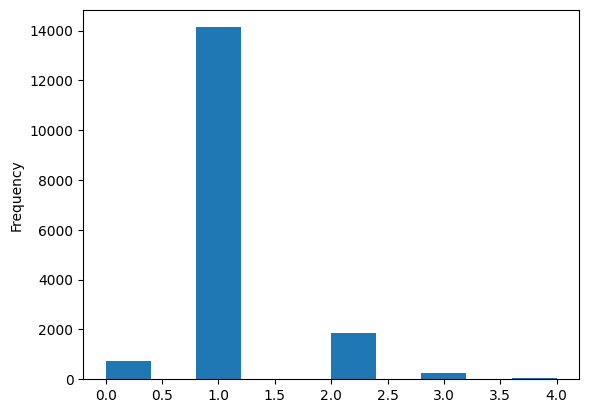

In [36]:
metrics_df['rank'].plot.hist(bins=10)

In [37]:
metrics_df.groupby('rank').count()

,u,v_pos,edge_type,ts,mrr,hits@1,hits@3,hits@10
rank,,,,,,,,
0.0,746,746,746,746,746,746,746,746
1.0,14134,14134,14134,14134,14134,14134,14134,14134
2.0,1852,1852,1852,1852,1852,1852,1852,1852
3.0,263,263,263,263,263,263,263,263
4.0,33,33,33,33,33,33,33,33


In [38]:
results = pd.read_csv("../data/transe/icews14/thesis-graph/iostv0db/train_val_0_scores.csv")
results

,edge_id,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos,length,score
0,307232,0,33,44,211,0,0,7296,2,1,3,211,0,0.000000
1,307233,177,56,567,13,0,0,7296,2,1,70,13,0,0.000000
2,307234,13,0,27,44,0,0,7296,2,1,9,44,0,0.000000
3,307235,1,0,53,44,0,0,7296,2,1,32,44,0,0.000000
4,307236,102,3,590,8,0,0,7296,2,1,41,8,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42565,349797,5,6771,72,6711,0,0,7992,2,0,32,943,5,0.383389
42566,349798,5,5235,72,6196,0,0,7992,2,0,32,943,5,0.374265
42567,349799,44,5241,88,5917,0,0,7992,2,0,13,8,5,0.402574
42568,349800,44,2991,88,5587,0,0,7992,2,0,13,8,4,0.408247


In [39]:
len(results)

42570

In [40]:
len(results[results['label'] == 0])

25542

In [41]:
len(results[results['label'] == 1])

17028

In [42]:
results.iloc[0]

edge_id       307232.0
feat_pos_u         0.0
feat_pos_v        33.0
u                 44.0
v                211.0
u_type             0.0
v_type             0.0
ts              7296.0
split              2.0
label              1.0
edge_type          3.0
v_pos            211.0
length             0.0
score              0.0
Name: 0, dtype: float64

In [43]:
result_df = pd.DataFrame(results)
result_df

,edge_id,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos,length,score
0,307232,0,33,44,211,0,0,7296,2,1,3,211,0,0.000000
1,307233,177,56,567,13,0,0,7296,2,1,70,13,0,0.000000
2,307234,13,0,27,44,0,0,7296,2,1,9,44,0,0.000000
3,307235,1,0,53,44,0,0,7296,2,1,32,44,0,0.000000
4,307236,102,3,590,8,0,0,7296,2,1,41,8,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42565,349797,5,6771,72,6711,0,0,7992,2,0,32,943,5,0.383389
42566,349798,5,5235,72,6196,0,0,7992,2,0,32,943,5,0.374265
42567,349799,44,5241,88,5917,0,0,7992,2,0,13,8,5,0.402574
42568,349800,44,2991,88,5587,0,0,7992,2,0,13,8,4,0.408247


In [44]:
result_df.describe()

,edge_id,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos,length,score
count,42570.000000,42570.000000,42570.000000,42570.000000,42570.000000,42570.0,42570.0,42570.000000,42570.0,42570.000000,42570.000000,42570.000000,42570.000000,42570.000000
mean,328516.500000,537.759126,2360.519192,1124.978130,2563.367559,0.0,0.0,7645.099366,2.0,0.400000,70.126028,1021.909349,2.598332,0.222302
std,12289.044816,1042.529011,2290.092918,1699.161599,2258.919709,0.0,0.0,195.250129,0.0,0.489904,95.835064,1636.696323,2.203067,0.191982
min,307232.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,7296.000000,2.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,317874.250000,16.000000,159.000000,74.000000,407.000000,0.0,0.0,7488.000000,2.0,0.000000,9.000000,70.000000,0.000000,0.000000
50%,328516.500000,105.000000,1624.000000,372.000000,1990.500000,0.0,0.0,7656.000000,2.0,0.000000,25.000000,288.000000,3.000000,0.330330
75%,339158.750000,514.000000,4283.000000,1264.000000,4498.000000,0.0,0.0,7800.000000,2.0,1.000000,70.000000,1119.750000,4.000000,0.401864
max,349801.000000,7116.000000,7127.000000,6892.000000,7127.000000,0.0,0.0,7992.000000,2.0,1.000000,457.000000,6892.000000,7.000000,0.478551


In [45]:
result_df.groupby(["u", "v_pos", "edge_type", "ts"]).count()

edge_id  feat_pos_u  feat_pos_v  v  u_type  v_type  \
u    v_pos edge_type ts                                                         
0    1     0         7536        4           4           4  4       4       4   
                     7560        4           4           4  4       4       4   
                     7608        4           4           4  4       4       4   
                     7680        4           4           4  4       4       4   
                     7728        4           4           4  4       4       4   
...                            ...         ...         ... ..     ...     ...   
6889 1115  231       7992        1           1           1  1       1       1   
6890 4363  3         7992        4           4           4  4       4       4   
           233       7992        1           1           1  1       1       1   
6891 53    12        7992        4           4           4  4       4       4   
6892 1897  18        7992        4           4           4  4       4       4   

                           split  label  length  score  
u    v_pos edge_type ts                                 
0    1     0         7536      4      4       4      4  
                     7560      4      4       4      4  
                     7608      4      4       4      4  
                     7680      4      4       4      4  
                     7728      4      4       4      4  
...                          ...    ...     ...    ...  
6889 1115  231       7992      1      1       1      1  
6890 4363  3         7992      4      4       4      4  
           233       7992      1      1       1      1  
6891 53    12        7992      4      4       4      4  
6892 1897  18        7992      4      4       4      4  

[17028 rows x 10 columns]

In [46]:
df.describe()

,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos
count,386657.000000,386657.000000,386657.000000,386657.000000,386657.0,386657.0,386657.000000,386657.000000,386657.000000,386657.000000,386657.000000
mean,554.105626,2165.932829,1017.557639,2344.083045,0.0,0.0,5028.674675,1.185224,0.469305,77.542633,937.041277
std,1059.865109,2257.650008,1497.732250,2219.876411,0.0,0.0,2257.209144,0.756682,0.499058,100.979240,1455.772646
min,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,110.000000,74.000000,293.000000,0.0,0.0,3288.000000,1.000000,0.000000,9.000000,72.000000
50%,113.000000,1257.000000,359.000000,1596.000000,0.0,0.0,5160.000000,1.000000,0.000000,26.000000,288.000000
75%,539.000000,3983.000000,1233.000000,4167.000000,0.0,0.0,6984.000000,1.000000,1.000000,114.000000,1056.000000
max,7127.000000,7127.000000,7127.000000,7127.000000,0.0,0.0,8736.000000,3.000000,1.000000,459.000000,7127.000000


In [47]:
df

,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label,edge_type,v_pos
edge_id,,,,,,,,,,,
0,19,151,0,1,0,0,0,0,1,0,1
1,2233,57,2,3,0,0,0,0,1,1,3
2,182,112,4,5,0,0,0,0,1,2,5
3,22,21,6,7,0,0,0,0,1,3,7
4,3,742,8,9,0,0,0,0,1,4,9
...,...,...,...,...,...,...,...,...,...,...,...
386652,347,3174,249,6306,0,0,8736,3,0,9,29
386653,347,3557,249,3128,0,0,8736,3,0,9,29
386654,1648,876,3509,1568,0,0,8736,3,0,18,459


In [48]:
test_df = pd.merge(df[df["split"] == 2], result_df, on=["u", "v_pos", "edge_type", "ts", "v", "label"])
test_df

,feat_pos_u_x,feat_pos_v_x,u,v,u_type_x,v_type_x,ts,split_x,label,edge_type,v_pos,edge_id,feat_pos_u_y,feat_pos_v_y,u_type_y,v_type_y,split_y,length,score
0,0,33,44,211,0,0,7296,2,1,3,211,307232,0,33,0,0,2,0,0.000000
1,177,56,567,13,0,0,7296,2,1,70,13,307233,177,56,0,0,2,0,0.000000
2,13,0,27,44,0,0,7296,2,1,9,44,307234,13,0,0,0,2,0,0.000000
3,1,0,53,44,0,0,7296,2,1,32,44,307235,1,0,0,0,2,0,0.000000
4,102,3,590,8,0,0,7296,2,1,41,8,307236,102,3,0,0,2,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42565,5,6771,72,6711,0,0,7992,2,0,32,943,349797,5,6771,0,0,2,5,0.383389
42566,5,5235,72,6196,0,0,7992,2,0,32,943,349798,5,5235,0,0,2,5,0.374265
42567,44,5241,88,5917,0,0,7992,2,0,13,8,349799,44,5241,0,0,2,5,0.402574
42568,44,2991,88,5587,0,0,7992,2,0,13,8,349800,44,2991,0,0,2,4,0.408247


In [49]:
test_df.groupby(["u", "v_pos", "edge_type", "ts"]).count()

feat_pos_u_x  feat_pos_v_x  v  u_type_x  v_type_x  \
u    v_pos edge_type ts                                                        
0    1     0         7536             4             4  4         4         4   
                     7560             4             4  4         4         4   
                     7608             4             4  4         4         4   
                     7680             4             4  4         4         4   
                     7728             4             4  4         4         4   
...                                 ...           ... ..       ...       ...   
6889 1115  231       7992             1             1  1         1         1   
6890 4363  3         7992             4             4  4         4         4   
           233       7992             1             1  1         1         1   
6891 53    12        7992             4             4  4         4         4   
6892 1897  18        7992             4             4  4         4         4   

                           split_x  label  edge_id  feat_pos_u_y  \
u    v_pos edge_type ts                                            
0    1     0         7536        4      4        4             4   
                     7560        4      4        4             4   
                     7608        4      4        4             4   
                     7680        4      4        4             4   
                     7728        4      4        4             4   
...                            ...    ...      ...           ...   
6889 1115  231       7992        1      1        1             1   
6890 4363  3         7992        4      4        4             4   
           233       7992        1      1        1             1   
6891 53    12        7992        4      4        4             4   
6892 1897  18        7992        4      4        4             4   

                           feat_pos_v_y  u_type_y  v_type_y  split_y  length  \
u    v_pos edge_type ts                                                        
0    1     0         7536             4         4         4        4       4   
                     7560             4         4         4        4       4   
                     7608             4         4         4        4       4   
                     7680             4         4         4        4       4   
                     7728             4         4         4        4       4   
...                                 ...       ...       ...      ...     ...   
6889 1115  231       7992             1         1         1        1       1   
6890 4363  3         7992             4         4         4        4       4   
           233       7992             1         1         1        1       1   
6891 53    12        7992             4         4         4        4       4   
6892 1897  18        7992             4         4         4        4       4   

                           score  
u    v_pos edge_type ts           
0    1     0         7536      4  
                     7560      4  
                     7608      4  
                     7680      4  
                     7728      4  
...                          ...  
6889 1115  231       7992      1  
6890 4363  3         7992      4  
           233       7992      1  
6891 53    12        7992      4  
6892 1897  18        7992      4  

[17028 rows x 15 columns]

In [50]:
test = result_df.groupby(["u", "v_pos", "edge_type", "ts"]).count()
test[test["v"] > 1]

edge_id  feat_pos_u  feat_pos_v  v  u_type  v_type  \
u    v_pos edge_type ts                                                         
0    1     0         7536        4           4           4  4       4       4   
                     7560        4           4           4  4       4       4   
                     7608        4           4           4  4       4       4   
                     7680        4           4           4  4       4       4   
                     7728        4           4           4  4       4       4   
...                            ...         ...         ... ..     ...     ...   
6883 607   9         7944        4           4           4  4       4       4   
6884 738   171       7968        4           4           4  4       4       4   
6890 4363  3         7992        4           4           4  4       4       4   
6891 53    12        7992        4           4           4  4       4       4   
6892 1897  18        7992        4           4           4  4       4       4   

                           split  label  length  score  
u    v_pos edge_type ts                                 
0    1     0         7536      4      4       4      4  
                     7560      4      4       4      4  
                     7608      4      4       4      4  
                     7680      4      4       4      4  
                     7728      4      4       4      4  
...                          ...    ...     ...    ...  
6883 607   9         7944      4      4       4      4  
6884 738   171       7968      4      4       4      4  
6890 4363  3         7992      4      4       4      4  
6891 53    12        7992      4      4       4      4  
6892 1897  18        7992      4      4       4      4  

[8514 rows x 10 columns]

In [51]:
from evaluation import evaluate
from collections import defaultdict

In [52]:
# edge_groups = defaultdict(lambda: {'pos_score': None, 'neg_scores': []})
# for item in results:
#     # Use v_pos as the target node for grouping, which is the true target for all edges
#     v_for_grouping = item.get('v_pos', item['v'])
#     key = (item['u'], item.get('edge_type'), v_for_grouping, item['ts'])
#     score = item['score']  # Now using the adjusted score
#     length = item['length']
    
#     if item['label'] == 1:
#         edge_groups[key]['pos_score'] = (score, length)
#     else:
#         edge_groups[key]['neg_scores'].append((score, length))

In [53]:
# final = evaluate(edge_groups, verbose=False)
final = evaluate(results, verbose=False)
final

({'rank': 0.25745830396993186,
  'mrr': 0.19572664630804168,
  'hits@1': 0.17952783650458068,
  'hits@3': 0.21300211416490486,
  'hits@10': 0.21441155743481324},
           u  v_pos  edge_type    ts  rank  mrr  hits@1  hits@3  hits@10
 0         0      1          0  7536   0.0  0.0     0.0     0.0      0.0
 1         0      1          0  7560   0.0  0.0     0.0     0.0      0.0
 2         0      1          0  7608   0.0  0.0     0.0     0.0      0.0
 3         0      1          0  7680   0.0  0.0     0.0     0.0      0.0
 4         0      1          0  7728   0.0  0.0     0.0     0.0      0.0
 ...     ...    ...        ...   ...   ...  ...     ...     ...      ...
 17023  6889   1115        231  7992   0.0  0.0     0.0     0.0      0.0
 17024  6890   4363          3  7992   0.0  0.0     0.0     0.0      0.0
 17025  6890   4363        233  7992   0.0  0.0     0.0     0.0      0.0
 17026  6891     53         12  7992   0.0  0.0     0.0     0.0      0.0
 17027  6892   1897         18  799

In [54]:
test_df

,feat_pos_u_x,feat_pos_v_x,u,v,u_type_x,v_type_x,ts,split_x,label,edge_type,v_pos,edge_id,feat_pos_u_y,feat_pos_v_y,u_type_y,v_type_y,split_y,length,score
0,0,33,44,211,0,0,7296,2,1,3,211,307232,0,33,0,0,2,0,0.000000
1,177,56,567,13,0,0,7296,2,1,70,13,307233,177,56,0,0,2,0,0.000000
2,13,0,27,44,0,0,7296,2,1,9,44,307234,13,0,0,0,2,0,0.000000
3,1,0,53,44,0,0,7296,2,1,32,44,307235,1,0,0,0,2,0,0.000000
4,102,3,590,8,0,0,7296,2,1,41,8,307236,102,3,0,0,2,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42565,5,6771,72,6711,0,0,7992,2,0,32,943,349797,5,6771,0,0,2,5,0.383389
42566,5,5235,72,6196,0,0,7992,2,0,32,943,349798,5,5235,0,0,2,5,0.374265
42567,44,5241,88,5917,0,0,7992,2,0,13,8,349799,44,5241,0,0,2,5,0.402574
42568,44,2991,88,5587,0,0,7992,2,0,13,8,349800,44,2991,0,0,2,4,0.408247


In [55]:
def process(group):
    return group.loc[group["label"] == 0, "length"].min()

In [56]:
test_df.groupby(["u", "v_pos", "edge_type", "ts"]).apply(process, include_groups=False)

u     v_pos  edge_type  ts  
0     1      0          7536    4.0
                        7560    4.0
                        7608    4.0
                        7680    4.0
                        7728    4.0
                               ... 
6889  1115   231        7992    NaN
6890  4363   3          7992    0.0
             233        7992    NaN
6891  53     12         7992    0.0
6892  1897   18         7992    0.0
Length: 17028, dtype: float64

In [57]:
check = pd.merge(result_df, plot_df, on=["u", "v", "v_pos", "ts", "edge_type"])
check

,edge_id,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label_x,edge_type,v_pos,length,score,path_length,label_y
0,307232,0,33,44,211,0,0,7296,2,1,3,211,0,0.000000,2,1
1,307233,177,56,567,13,0,0,7296,2,1,70,13,0,0.000000,2,1
2,307234,13,0,27,44,0,0,7296,2,1,9,44,0,0.000000,2,1
3,307235,1,0,53,44,0,0,7296,2,1,32,44,0,0.000000,2,1
4,307236,102,3,590,8,0,0,7296,2,1,41,8,0,0.000000,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42565,349797,5,6771,72,6711,0,0,7992,2,0,32,943,5,0.383389,5,0
42566,349798,5,5235,72,6196,0,0,7992,2,0,32,943,5,0.374265,5,0
42567,349799,44,5241,88,5917,0,0,7992,2,0,13,8,5,0.402574,5,0
42568,349800,44,2991,88,5587,0,0,7992,2,0,13,8,4,0.408247,4,0


In [58]:
check_df = check[check['length'] != check['path_length']]
check_df

,edge_id,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label_x,edge_type,v_pos,length,score,path_length,label_y
0,307232,0,33,44,211,0,0,7296,2,1,3,211,0,0.0,2,1
1,307233,177,56,567,13,0,0,7296,2,1,70,13,0,0.0,2,1
2,307234,13,0,27,44,0,0,7296,2,1,9,44,0,0.0,2,1
3,307235,1,0,53,44,0,0,7296,2,1,32,44,0,0.0,2,1
4,307236,102,3,590,8,0,0,7296,2,1,41,8,0,0.0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42048,349280,3215,629,4003,786,0,0,7992,2,1,230,786,0,0.0,2,1
42049,349281,1,14,53,95,0,0,7992,2,1,239,95,0,0.0,2,1
42054,349286,8,77,74,5737,0,0,7992,2,1,239,5737,0,0.0,2,1
42055,349287,94,5,943,72,0,0,7992,2,1,262,72,0,0.0,2,1


In [59]:
check_df.describe()

,edge_id,feat_pos_u,feat_pos_v,u,v,u_type,v_type,ts,split,label_x,edge_type,v_pos,length,score,path_length,label_y
count,12650.000000,12650.000000,12650.000000,12650.000000,12650.000000,12650.0,12650.0,12650.000000,12650.0,12650.000000,12650.000000,12650.000000,12650.0,12650.0,12650.000000,12650.000000
mean,327814.403399,275.571462,273.168617,734.879684,721.385929,0.0,0.0,7641.171225,2.0,0.998498,138.848142,715.722688,0.0,0.0,2.021107,0.998498
std,12285.192796,567.109247,589.508090,1248.810924,1249.570813,0.0,0.0,195.397884,0.0,0.038728,118.150257,1240.791919,0.0,0.0,0.177687,0.038728
min,307232.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,7296.000000,2.0,0.000000,0.000000,0.000000,0.0,0.0,2.000000,0.000000
25%,317530.250000,10.000000,9.000000,53.000000,53.000000,0.0,0.0,7488.000000,2.0,1.000000,16.000000,53.000000,0.0,0.0,2.000000,1.000000
50%,327780.500000,54.000000,49.000000,196.000000,165.000000,0.0,0.0,7632.000000,2.0,1.000000,156.000000,162.000000,0.0,0.0,2.000000,1.000000
75%,338487.750000,242.000000,231.000000,818.000000,803.000000,0.0,0.0,7800.000000,2.0,1.000000,246.000000,799.000000,0.0,0.0,2.000000,1.000000
max,349288.000000,5273.000000,7088.000000,6882.000000,6882.000000,0.0,0.0,7992.000000,2.0,1.000000,456.000000,6882.000000,0.0,0.0,7.000000,1.000000
